In [1]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Load data

In [75]:
data = pd.read_csv('AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [76]:
print('Number of columns: {}'.format(data.shape[1]))
print('Number of rows: {}'.format(data.shape[0]))

Number of columns: 16
Number of rows: 48895


In [77]:
data.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [78]:
data['last_review'] = pd.to_datetime(data['last_review'],infer_datetime_format=True) 

# Preprocessing 

## Handling Missing data

In [79]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum())/data.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(40)

,Total,Percent
reviews_per_month,10052,0.205583
last_review,10052,0.205583
host_name,21,0.000429
name,16,0.000327
availability_365,0,0.000000
calculated_host_listings_count,0,0.000000
number_of_reviews,0,0.000000
minimum_nights,0,0.000000
price,0,0.000000
room_type,0,0.000000


In [80]:
data.drop(['host_name','name'], axis=1, inplace=True)

In [81]:
data[data['number_of_reviews']== 0.0].shape

(10052, 14)

The NaN values in the last_review and reviews_per_month columns all occur for examples where no reviews were given in the first place. 

For reviews_per_month,fill with 0's.

In [82]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

In [83]:
first = min(data['last_review'])
data['last_review'] = data['last_review'].fillna(first)
data['last_review'] = data['last_review'].apply(lambda x: x.toordinal() - first.toordinal())

In [84]:
total = data.isnull().sum().sort_values(ascending=False) 
percent = (data.isnull().sum())/data.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(40)

,Total,Percent
availability_365,0,0.0
calculated_host_listings_count,0,0.0
reviews_per_month,0,0.0
last_review,0,0.0
number_of_reviews,0,0.0
minimum_nights,0,0.0
price,0,0.0
room_type,0,0.0
longitude,0,0.0
latitude,0,0.0


##  EDA on target variable

## Distribution of Price

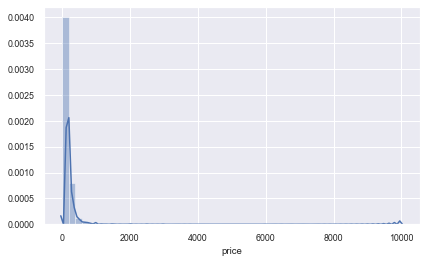

In [85]:
sns.distplot(data['price'])

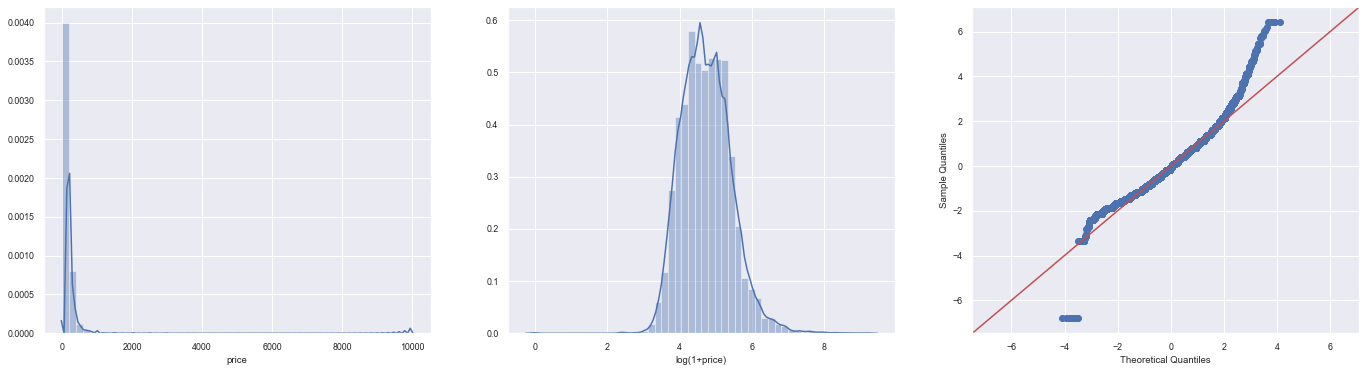

In [86]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['price'], ax=axes[0])
sns.distplot(np.log1p(data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [87]:
data = data[np.log1p(data['price']) < 8]
data = data[np.log1p(data['price']) > 3]

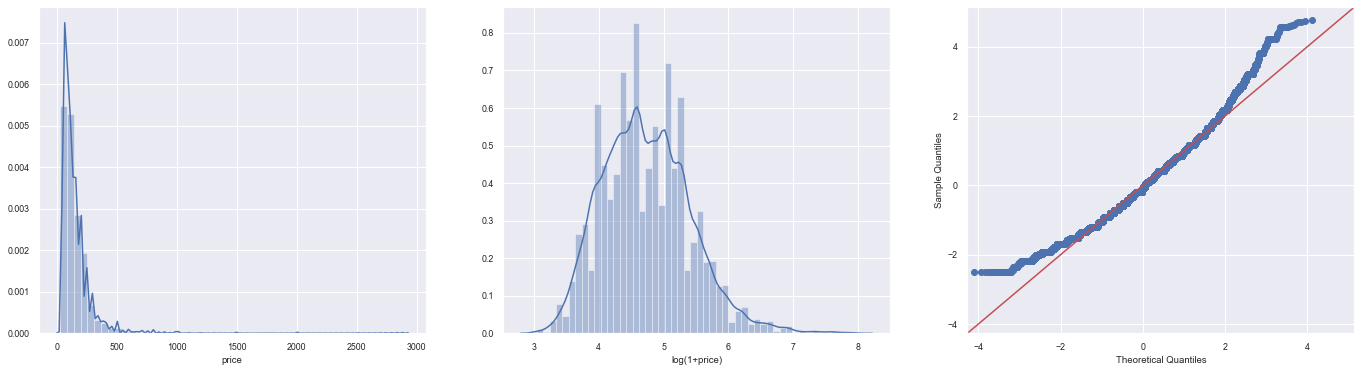

In [88]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['price'], ax=axes[0])
sns.distplot(np.log1p(data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [89]:
data['price'] = np.log1p(data['price'])

## Univariate Analysis

###  Host_id

In [90]:
print('In this dataset there are {} unique hosts renting out  a total number of {} properties which is not going to be helpful as the number of values is equal to the total number of values.'.format(len(data['host_id'].unique()), data.shape[0]))

In this dataset there are 37384 unique hosts renting out  a total number of 48784 properties which is not going to be helpful as the number of values is equal to the total number of values.


In [91]:
data = data.drop(['host_id', 'id'], axis=1)

###  Neighbourhood group

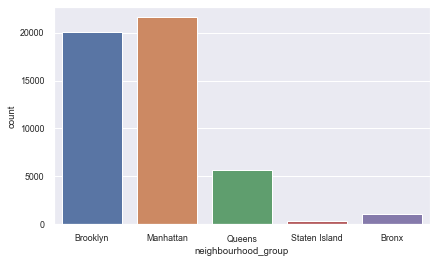

In [92]:
sns.countplot(x='neighbourhood_group',data=data)

We see that Manahattan and brooklyn has most number of rental places, which means they are bigger tourist spots or business hubs.

###  Longitude and latitude

Longitude and latitude are correlated with each other. 

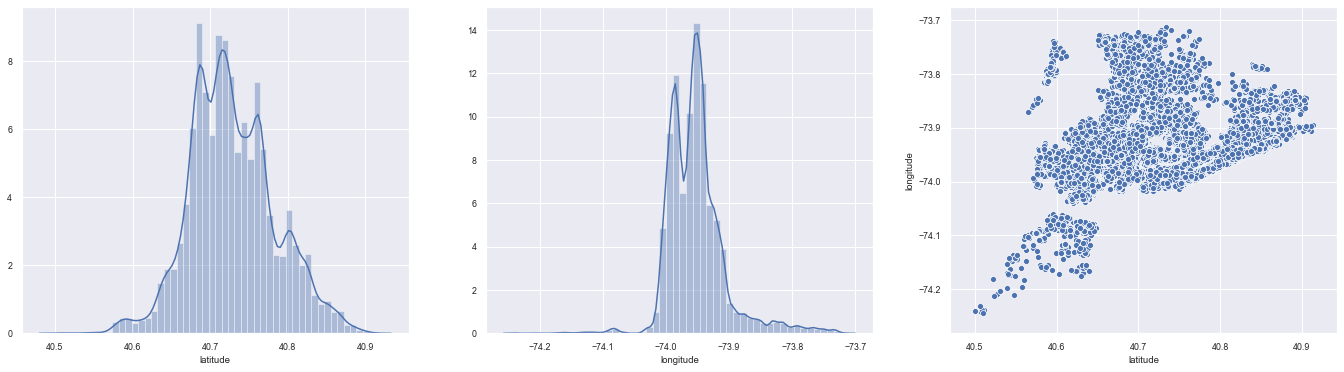

In [93]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['latitude'], ax=axes[0])
sns.distplot(data['longitude'], ax=axes[1])
sns.scatterplot(x= data['latitude'], y=data['longitude'])

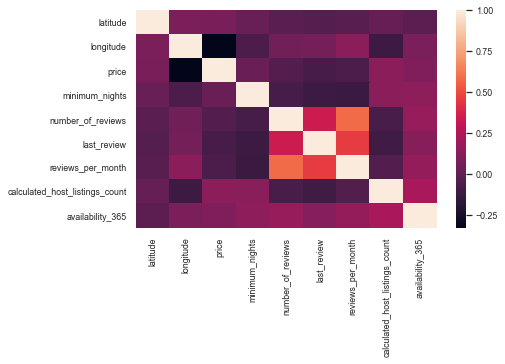

In [94]:
sns.heatmap(data.corr())

### Room type

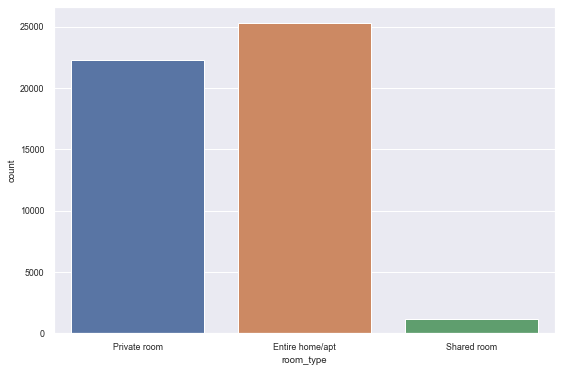

In [95]:
sns.countplot(x='room_type' ,data=data)
fig = plt.gcf()
fig.set_size_inches(8, 6)

### Minimum nights

Text(0, 0.5, 'count')

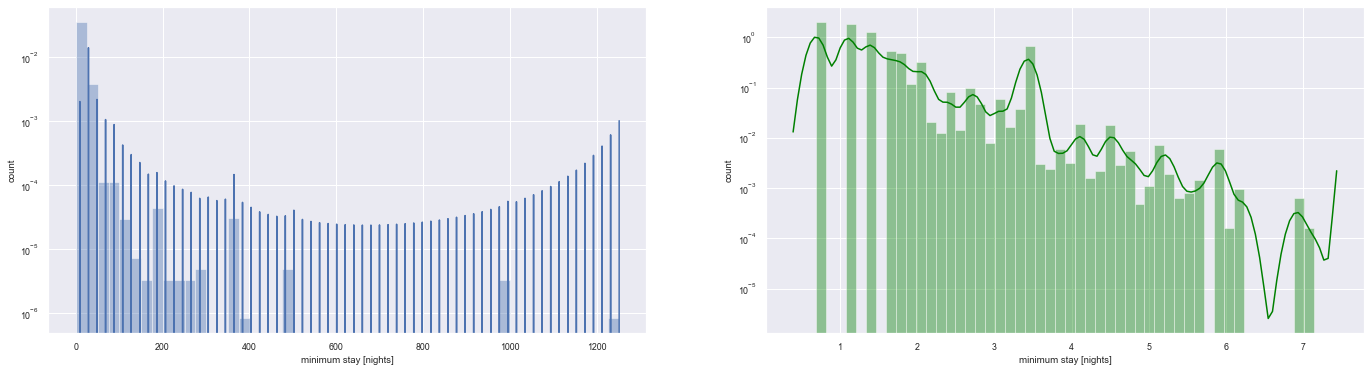

In [96]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))

sns.distplot(data['minimum_nights'], ax = axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('minimum stay [nights]')
axes[0].set_ylabel('count')

sns.distplot(np.log1p(data['minimum_nights']), color="green", ax = axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('minimum stay [nights]')
axes[1].set_ylabel('count')

In [97]:
data['minimum_nights'] = np.log1p(data['minimum_nights'])

###  Reviews per month

Text(0.5, 0, 'ln(reviews_per_month)')

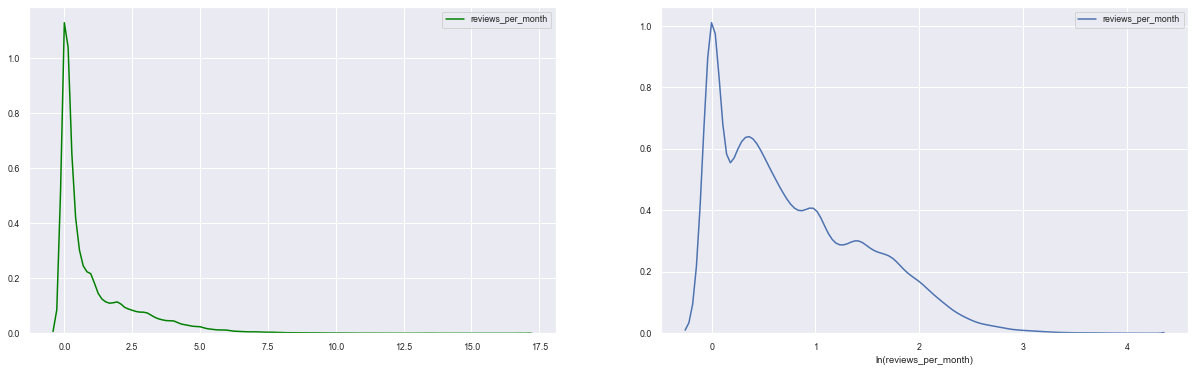

In [98]:
fig, axes = plt.subplots(1,2,figsize=(18.5, 6))
sns.kdeplot(data[data['reviews_per_month'] < 17.5]['reviews_per_month'], color="green", ax=axes[0])
sns.kdeplot(np.sqrt(data[data['reviews_per_month'] < 17.5]['reviews_per_month']), ax=axes[1])
axes[1].set_xlabel('ln(reviews_per_month)')

This variable is skewed even after log transformation

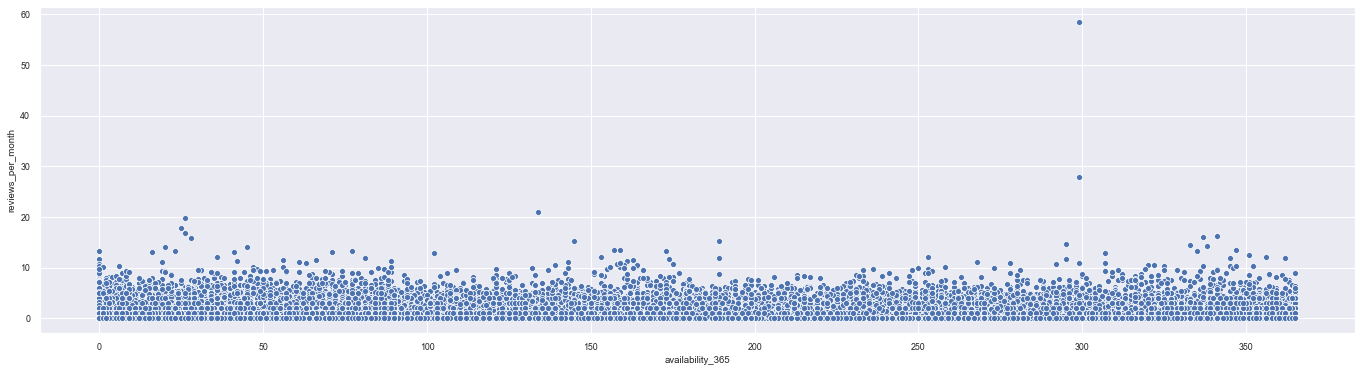

In [99]:
fig, axes = plt.subplots(1,1, figsize=(21,6))
sns.scatterplot(x= data['availability_365'], y=data['reviews_per_month'])

In [100]:
data['reviews_per_month'] = data[data['reviews_per_month'] < 17.5]['reviews_per_month']

### 1.4.7 Availability_365

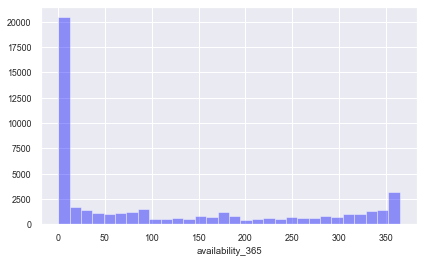

In [101]:
sns.distplot(data['availability_365'], rug=False, kde=False, color="blue")

### Feature engineering

In [102]:
data['all_year_avail'] = data['availability_365']>353
data['low_avail'] = data['availability_365']< 12
data['no_reviews'] = data['reviews_per_month']==0

## Bivariate correlations

### Heat Map

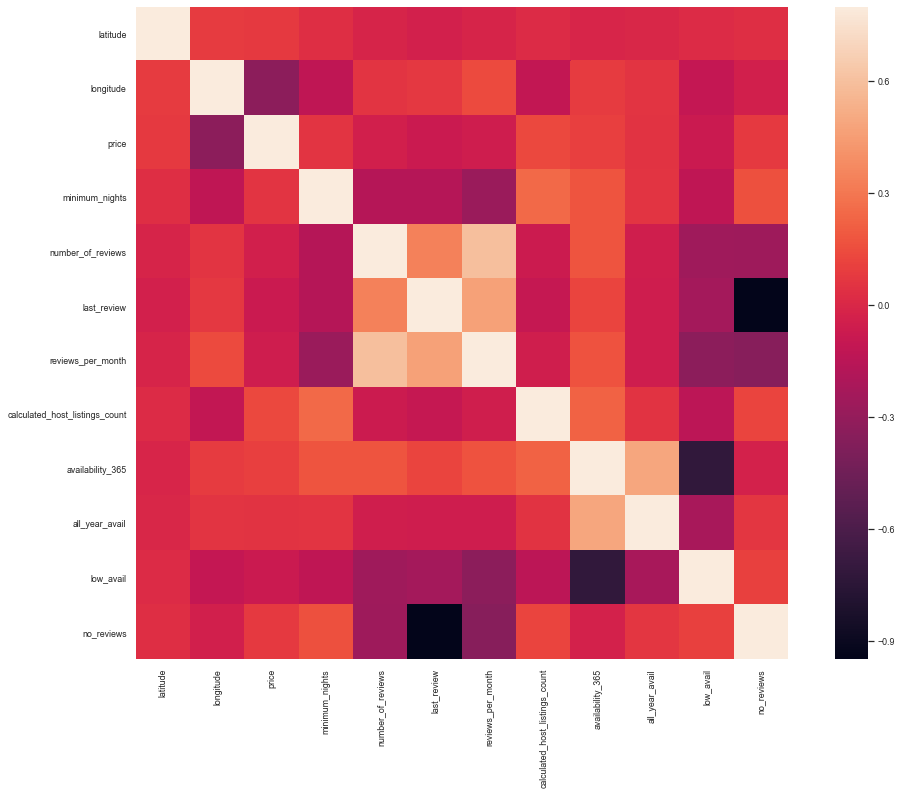

In [103]:
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(data.corr(), vmax=0.8, square=True)
sns.set(font_scale=0.8)

There appears a correlation between number of reviews and reviews per month.

##  Encoding categorical features

In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48784 entries, 0 to 48894
Data columns (total 15 columns):
neighbourhood_group               48784 non-null object
neighbourhood                     48784 non-null object
latitude                          48784 non-null float64
longitude                         48784 non-null float64
room_type                         48784 non-null object
price                             48784 non-null float64
minimum_nights                    48784 non-null float64
number_of_reviews                 48784 non-null int64
last_review                       48784 non-null int64
reviews_per_month                 48779 non-null float64
calculated_host_listings_count    48784 non-null int64
availability_365                  48784 non-null int64
all_year_avail                    48784 non-null bool
low_avail                         48784 non-null bool
no_reviews                        48784 non-null bool
dtypes: bool(3), float64(5), int64(4), object(3)
memory 

In [105]:
data.columns

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'all_year_avail', 'low_avail', 'no_reviews'],
      dtype='object')

In [106]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [107]:
data['neighbourhood']=le.fit_transform(data['neighbourhood'])
data['room_type']=le.fit_transform(data['room_type'])

In [108]:
data['neighbourhood_group']=le.fit_transform(data['neighbourhood_group'])

In [109]:
data['all_year_avail']=le.fit_transform(data['all_year_avail'])
data['low_avail']=le.fit_transform(data['low_avail'])
data['no_reviews']=le.fit_transform(data['no_reviews'])

In [110]:
data.head(5)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,all_year_avail,low_avail,no_reviews
0,1,108,40.64749,-73.97237,1,5.010635,0.693147,9,2762,0.21,6,365,1,0,0
1,2,127,40.75362,-73.98377,0,5.420535,0.693147,45,2976,0.38,2,355,1,0,0
2,2,94,40.80902,-73.94190,1,5.017280,1.386294,0,0,0.00,1,365,1,0,1
3,1,41,40.68514,-73.95976,0,4.499810,0.693147,270,3021,4.64,1,194,0,0,0
4,2,61,40.79851,-73.94399,0,4.394449,2.397895,9,2793,0.10,1,0,0,1,0


In [111]:
from sklearn.model_selection import train_test_split
X=data.drop(['price','reviews_per_month'],axis=1)
y= data['price']

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [113]:
lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

In [114]:
from sklearn.metrics import *

In [115]:
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)
rmse

0.48251484087478946

In [116]:
print(" Training score:",r2_score(y_test,y_pred))

 Training score: 0.5011765229103867


In [117]:
basemscore=r2_score(y_test,y_pred)

In [118]:
X.columns

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'minimum_nights', 'number_of_reviews', 'last_review',
       'calculated_host_listings_count', 'availability_365', 'all_year_avail',
       'low_avail', 'no_reviews'],
      dtype='object')

In [120]:
cols=['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'minimum_nights', 'number_of_reviews', 'last_review',
       'calculated_host_listings_count', 'availability_365', 'all_year_avail',
       'low_avail', 'no_reviews']
pmax=1
print(cols)

while(len(cols)>0):
    p=[]
    x=X[cols]
    Xc=sm.add_constant(x)
    model=sm.OLS(y,Xc).fit()
    p=pd.Series(model.pvalues.values[1:],index=cols)
    pmax=max(p)
    feature_with_p_max=p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
    selected_features_BE=cols
print(selected_features_BE)
print("The features selected that have pvalue less than 0.05: ",len(selected_features_BE))
print("Total number of columns initially: ",len(X.columns))

['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights', 'number_of_reviews', 'last_review', 'calculated_host_listings_count', 'availability_365', 'all_year_avail', 'low_avail', 'no_reviews']
['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights', 'number_of_reviews', 'last_review', 'calculated_host_listings_count', 'availability_365', 'all_year_avail', 'low_avail', 'no_reviews']
The features selected that have pvalue less than 0.05:  13
Total number of columns initially:  13


In [121]:
X=data[['neighbourhood_group', 'neighbourhood', 'room_type', 'minimum_nights', 'number_of_reviews', 'last_review', 'calculated_host_listings_count', 'availability_365', 'all_year_avail', 'low_avail']]
y= data['price']

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [123]:
lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

In [124]:
r2_score(y_test,y_pred)

0.42641519020021834

In [125]:
SFEscore=r2_score(y_test,y_pred)

In [126]:
from sklearn.linear_model import Ridge,Lasso,LinearRegression

In [127]:
m1=LinearRegression()
m2=Ridge(alpha=0.5,normalize=True)
m3=Lasso(alpha=0.1,normalize=True)

In [128]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=5,shuffle=True,random_state=0)

for model,name in zip([m1,m2,m3],['LR','Ridge','Lasso']):
    r2=[]
    print(name)
    for train,test in kf.split(X,y):
        X_train,X_test=X.iloc[train,:],X.iloc[test,:]
        y_train,y_test=y.iloc[train],y.iloc[test]
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        r2.append(r2_score(y_test,y_pred))
    print('R2:',r2) 
    print("Mean R2 score: ",np.mean(r2))

LR
R2: [0.44927643471171186, 0.43842793152882387, 0.4286364467881236, 0.4428242634615067, 0.42318843558512]
Mean R2 score:  0.43647070241505725
Ridge
R2: [0.3924959985858383, 0.38396538052701856, 0.38426508291271555, 0.3879748929587087, 0.3767430494507641]
Mean R2 score:  0.38508888088700904
Lasso
R2: [-0.00012246344502919726, -1.0657568384697669e-05, -1.531695608902872e-05, -2.5254061186474885e-05, -4.505413476785236e-05]
Mean R2 score:  -4.374923309145018e-05


In [129]:
LRcv=0.43647070241505725
ridgecv=0.38508888088700904
lassocv=-4.374923309145018e-05

In [130]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [131]:
X=data[['neighbourhood_group', 'neighbourhood', 'room_type', 'minimum_nights', 'number_of_reviews', 'last_review', 'calculated_host_listings_count', 'availability_365', 'all_year_avail', 'low_avail']]
y= data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [132]:
vif=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
pd.DataFrame({'vif':vif},index=X.columns)

,vif
neighbourhood_group,5.122111
neighbourhood,3.267362
room_type,1.781475
minimum_nights,3.714906
number_of_reviews,1.540945
last_review,4.041380
calculated_host_listings_count,1.189788
availability_365,4.350527
all_year_avail,1.519158
low_avail,2.779445


In [133]:
X=data[[ 'neighbourhood', 'room_type', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'all_year_avail', 'low_avail']]
y= data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [134]:
lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

In [135]:
vifreg=r2_score(y_test,y_pred)
vifreg

0.4336594205358093

In [136]:
from sklearn.preprocessing import PolynomialFeatures
pf=PolynomialFeatures() 

In [137]:
x=pf.fit_transform(X)
list=pf.get_feature_names(X.columns)
x=pd.DataFrame(x,columns=list)
x.head()

,1,neighbourhood,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,all_year_avail,low_avail,neighbourhood^2,neighbourhood room_type,...,number_of_reviews^2,number_of_reviews calculated_host_listings_count,number_of_reviews all_year_avail,number_of_reviews low_avail,calculated_host_listings_count^2,calculated_host_listings_count all_year_avail,calculated_host_listings_count low_avail,all_year_avail^2,all_year_avail low_avail,low_avail^2
0,1.0,108.0,1.0,0.693147,9.0,6.0,1.0,0.0,11664.0,108.0,...,81.0,54.0,9.0,0.0,36.0,6.0,0.0,1.0,0.0,0.0
1,1.0,127.0,0.0,0.693147,45.0,2.0,1.0,0.0,16129.0,0.0,...,2025.0,90.0,45.0,0.0,4.0,2.0,0.0,1.0,0.0,0.0
2,1.0,94.0,1.0,1.386294,0.0,1.0,1.0,0.0,8836.0,94.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
3,1.0,41.0,0.0,0.693147,270.0,1.0,0.0,0.0,1681.0,0.0,...,72900.0,270.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,61.0,0.0,2.397895,9.0,1.0,0.0,1.0,3721.0,0.0,...,81.0,9.0,0.0,9.0,1.0,0.0,1.0,0.0,0.0,1.0


In [138]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [139]:
lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
Polynomialreg=r2_score(y_test,y_pred)
Polynomialreg

0.4547081296787725

In [140]:
from sklearn.ensemble import RandomForestRegressor 

In [141]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [142]:
model = RandomForestRegressor(n_jobs=-1)

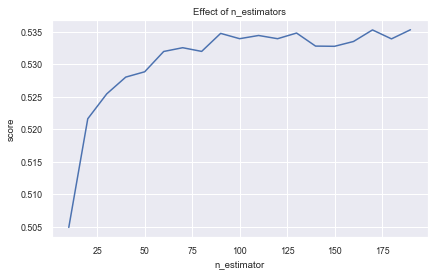

In [143]:
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [144]:
model.set_params(n_estimators=500)
model.fit(X_train, y_train)
RFreg=model.score(X_test, y_test)
RFreg

0.5358173858229855

# Summary

In [145]:
df = {'Models':['Base Model', 'Model after feature selection', 'LRCV', 'RidgeCV','Lasso CV','After VIF','Polynomialreg','Random Forest Regressor'], 'Scores':[basemscore,SFEscore,LRcv,ridgecv,lassocv,vifreg,Polynomialreg,RFreg]}
summary=pd.DataFrame(data=df)
summary      

,Models,Scores
0,Base Model,0.501177
1,Model after feature selection,0.426415
2,LRCV,0.436471
3,RidgeCV,0.385089
4,Lasso CV,-0.000044
5,After VIF,0.433659
6,Polynomialreg,0.454708
7,Random Forest Regressor,0.535817


Random Forest regressor gives the highest accuracy. Hence the chance of applying the smart price for the airbnb rental properties is more than 50% accurate